In [15]:
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing
import random
import os
%matplotlib widget




In [16]:
# Define the path to the checkpoint and the model type
checkpoint_path = "checkpoints/sam_checkpoint.pth"  # Path to the downloaded checkpoint
model_type = "default"  # Replace with the actual model type, e.g., "default"

# Load the model
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
predictor = SamPredictor(sam)





In [26]:
def process_image(image_path):
    # Load the image
    image = Image.open(image_path)
    image_np = np.array(image)

    # Set the image in the predictor
    predictor.set_image(image_np)

    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

    # Adjust the color range for a brighter yellow object to exclude shadows
    lower_yellow = np.array([140, 50, 100])  # Provided range
    upper_yellow = np.array([170, 255, 255])

    # Create a mask for the yellow object
    mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    # Find contours of the object
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get a point near the center of the largest contour assuming it's the object
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Sample points from within the largest contour
        sample_points = largest_contour[:, 0, :]
        
        # Select a point near the center of the contour by averaging
        cX = np.mean(sample_points[:, 0])
        cY = np.mean(sample_points[:, 1])
        foreground_point = (int(cX), int(cY))
    else:
        foreground_point = (0, 0)  # Default to (0, 0) if no contour is found

    # Combine points and labels
    input_points = np.array([foreground_point])
    input_labels = np.array([1])  # 1 for foreground

    print(f"Selected point for {os.path.basename(image_path)}:", input_points)

    # Generate masks
    masks, _, _ = predictor.predict(point_coords=input_points, point_labels=input_labels)

    # Define a function to overlay a colored mask on the image
    def overlay_mask(image, mask, color, alpha=0.5):
        """Overlay a colored mask on the image."""
        colored_image = image.copy()
        for i in range(3):  # Apply color to each channel
            colored_image[:, :, i] = np.where(mask == 1, color[i], image[:, :, i])
        return cv2.addWeighted(colored_image, alpha, image, 1 - alpha, 0)

    # Choose a color for the mask (e.g., green)
    mask_color = [0, 255, 0]  # Green color

    # Display the original image with the selected point
    plt.imshow(image_np)
    plt.scatter(input_points[:, 0], input_points[:, 1], c='red', s=100, marker='x')  # Highlight the selected point
    plt.show()

    # Assuming the desired mask is the second one (mask 2)
    desired_mask_index = 2

    if desired_mask_index < len(masks):
        mask_np = masks[desired_mask_index].astype(np.uint8)

        # Overlay the desired mask and display the result
        colored_mask_image = overlay_mask(image_np, mask_np, mask_color)
        plt.figure()
        plt.title(f"Desired Mask {desired_mask_index} for {os.path.basename(image_path)}")
        plt.imshow(colored_mask_image)
        plt.show()

        # Save the desired mask
        mask_image = Image.fromarray(mask_np * 255)
        mask_image.save(f"desired_mask_{desired_mask_index}_{os.path.basename(image_path)}.png")
    else:
        print(f"No mask found at index {desired_mask_index} for {os.path.basename(image_path)}.")




Selected point for pinknote1.jpg: [[1046 1094]]


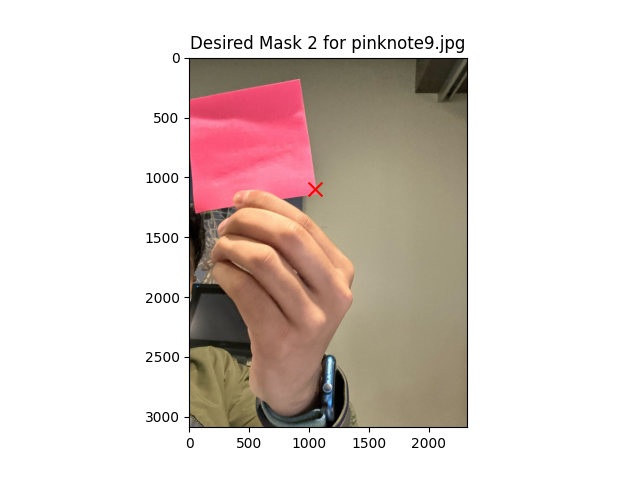

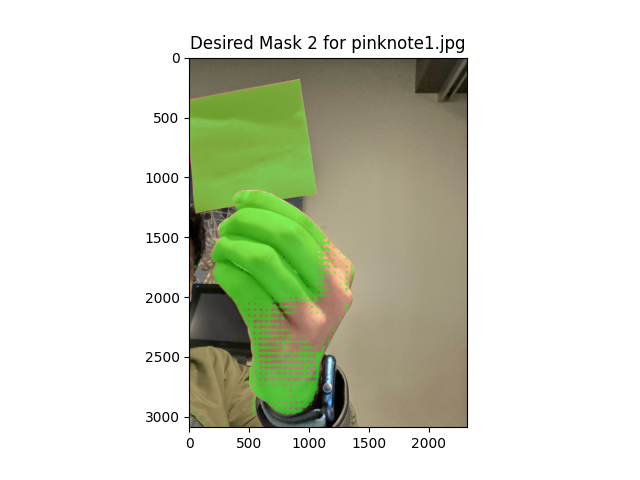

Selected point for pinknote2.jpg: [[1027  795]]


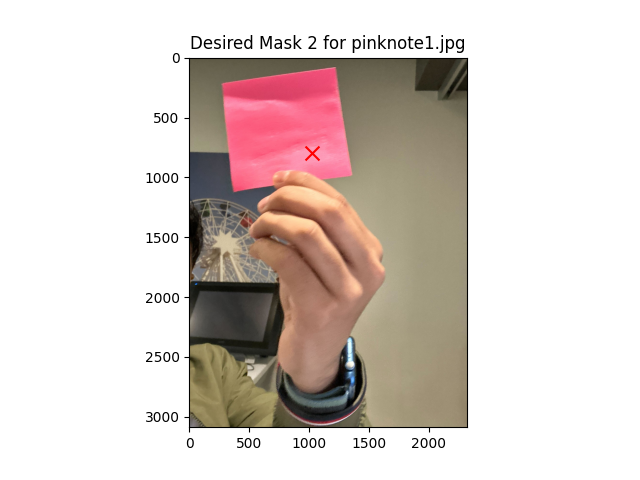

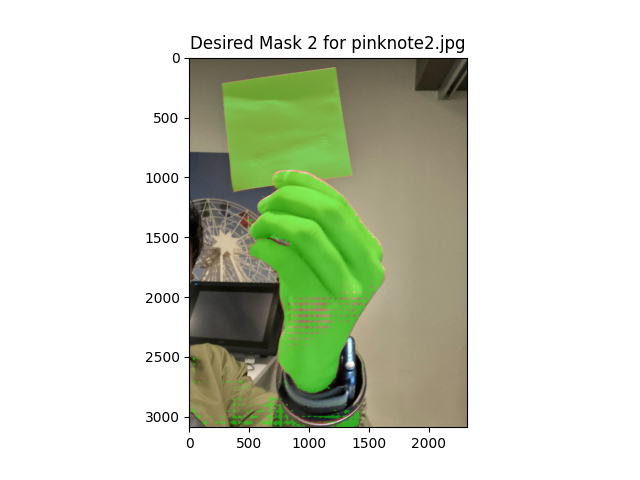

Selected point for pinknote3.jpg: [[ 373 1003]]


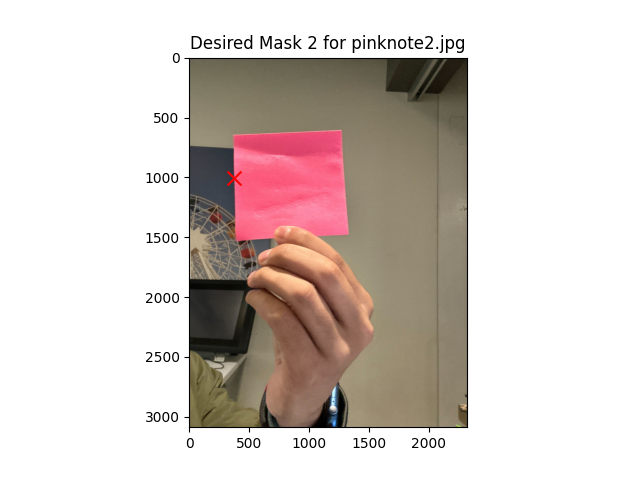

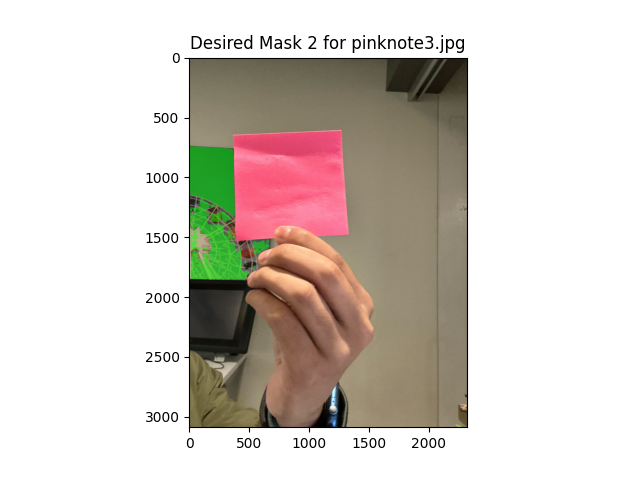

Selected point for pinknote4.jpg: [[172 654]]


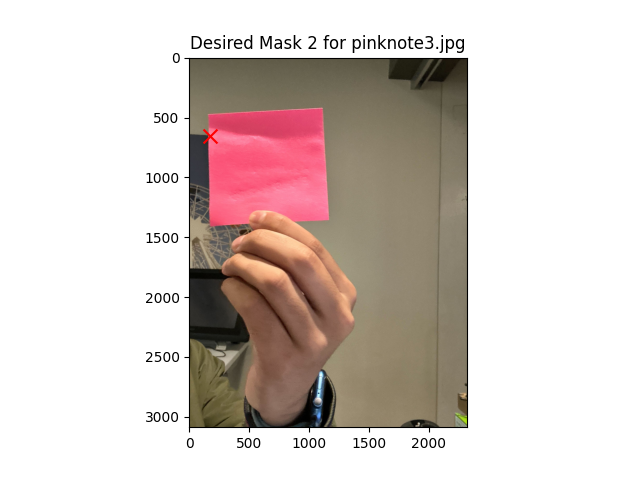

C:\Users\khand\AppData\Local\Temp\ipykernel_34520\931998859.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


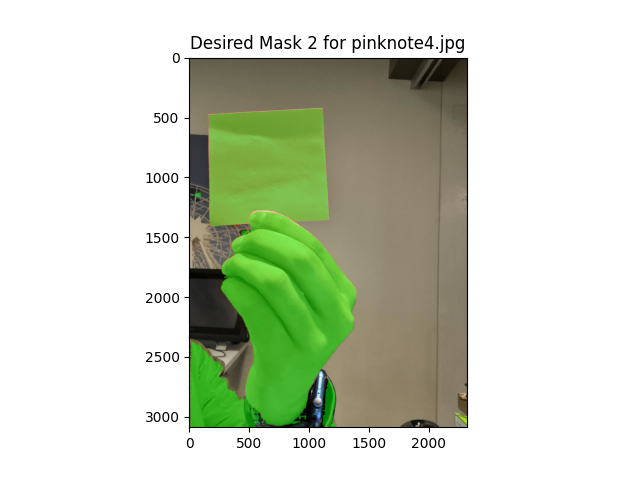

Selected point for pinknote5.jpg: [[349 692]]


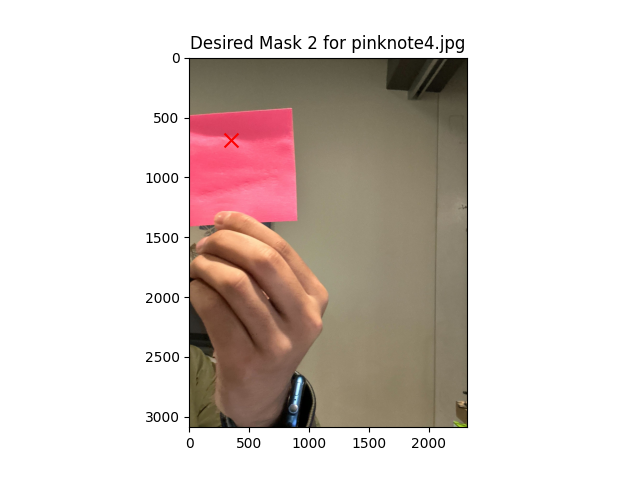

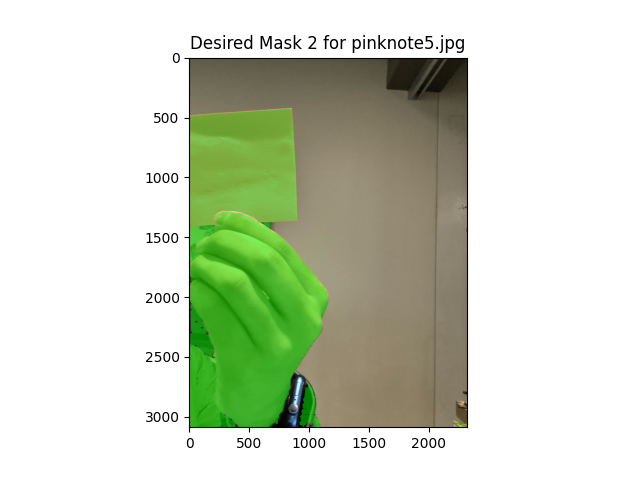

In [27]:
# List of image paths to process
image_paths = [
    f"images/pinknote/pinknote{i}.jpg" for i in range(1,10)  
]


#Process each image
for image_path in image_paths:
   process_image(image_path)
